In [9]:
import requests
from pytz import timezone
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
import seaborn as sns
import pandas as pd

- explorar API: https://api.cammesa.com/demanda-svc/demanda/RegionesDemanda
- de lo anterior, hacer algo mas mejor de los graficos: https://cammesaweb.cammesa.com/
- Para mapa con flujo de potencias: https://api.cammesa.com/demanda-svc/demanda/IntercambioCorredoresGeo

In [2]:
api_regiones_demanda = 'https://api.cammesa.com/demanda-svc/demanda/RegionesDemanda'
response = requests.get(api_regiones_demanda)
response.status_code

200

In [3]:
regiones_demanda = list(response.json())
regiones_demanda[:3]

[{'idElemento': 540022, 'nombre': 'Misiones', 'idPadre': 535042, 'id': 2426},
 {'idElemento': 540024, 'nombre': 'Corrientes', 'idPadre': 535042, 'id': 1893},
 {'idElemento': 540025, 'nombre': 'Chaco', 'idPadre': 535042, 'id': 1892}]

In [4]:
# Estos endpoint se completa con el id de alguna region al final
# Ejemplo: https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegion?id_region=1002
api_demanda_temp = 'https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegion?id_region='
api_generacion = 'https://api.cammesa.com/demanda-svc/generacion/ObtieneGeneracioEnergiaPorRegion?id_region='

In [5]:
region = regiones_demanda[-1]

dem_gen_region = {
    'demanda': [],
    'generacion': [],
}
response_dem = requests.get(api_demanda_temp + str(region.get('id')))
response_gen = requests.get(api_generacion + str(region.get('id')))

if response_dem.status_code == 200 and response_gen.status_code == 200:
    dem_gen_region['demanda'] = list(response_dem.json())
    dem_gen_region['generacion'] = list(response_gen.json())

print('Muestra de demanda:', dem_gen_region['demanda'][:2])
print('Muestra de generacion:', dem_gen_region['generacion'][:2])

Muestra de demanda: [{'fecha': '2023-07-29T00:00:00.000-0300', 'demHoy': 19479, 'demAyer': 19857, 'demSemanaAnt': 16255, 'demPrevista': 18725, 'tempHoy': 10.3, 'tempAyer': 8.4, 'tempSemanaAnt': 20.3}, {'fecha': '2023-07-29T00:05:00.000-0300', 'demHoy': 19258, 'demAyer': 19595, 'demSemanaAnt': 16174}]
Muestra de generacion: [{'fecha': '2023-07-29T00:00:00.000-0300', 'sumTotal': 19492.600000000002, 'hidraulico': 6265.2, 'termico': 8963.1, 'nuclear': 1022.0, 'renovable': 3242.3}, {'fecha': '2023-07-29T00:05:00.000-0300', 'sumTotal': 19324.3, 'hidraulico': 6086.1, 'termico': 8972.6, 'nuclear': 1019.5, 'renovable': 3246.1}]


Algo a tener en cuenta es que no siempre tendremos generación de energía dado que, por obvias razones, no todas las regiones generan energía. Por lo que solo se van a visualizar las de demanda de energía en estos casos.

## Análisis de Demanda

In [6]:
df_demanda = pd.DataFrame(dem_gen_region['demanda'])
df_demanda['fecha'] = pd.to_datetime(df_demanda['fecha'])
df_demanda['hora'] = df_demanda['fecha'].dt.hour
df_demanda

,fecha,demHoy,demAyer,demSemanaAnt,demPrevista,tempHoy,tempAyer,tempSemanaAnt,tempPrevista,hora
0,2023-07-29 00:00:00-03:00,19479.0,19857,16255,18725.0,10.3,8.4,20.3,NaN,0
1,2023-07-29 00:05:00-03:00,19258.0,19595,16174,NaN,NaN,NaN,NaN,NaN,0
2,2023-07-29 00:10:00-03:00,19139.0,19531,16110,NaN,NaN,NaN,NaN,NaN,0
3,2023-07-29 00:15:00-03:00,19045.0,19454,16013,NaN,10.2,7.7,20.4,NaN,0
4,2023-07-29 00:20:00-03:00,18853.0,19306,16028,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
284,2023-07-29 23:40:00-03:00,NaN,19883,15600,NaN,NaN,NaN,NaN,NaN,23
285,2023-07-29 23:45:00-03:00,NaN,19750,15561,NaN,NaN,10.2,13.1,NaN,23
286,2023-07-29 23:50:00-03:00,NaN,19671,15483,NaN,NaN,NaN,NaN,NaN,23
287,2023-07-29 23:55:00-03:00,NaN,19588,15420,NaN,NaN,NaN,NaN,NaN,23


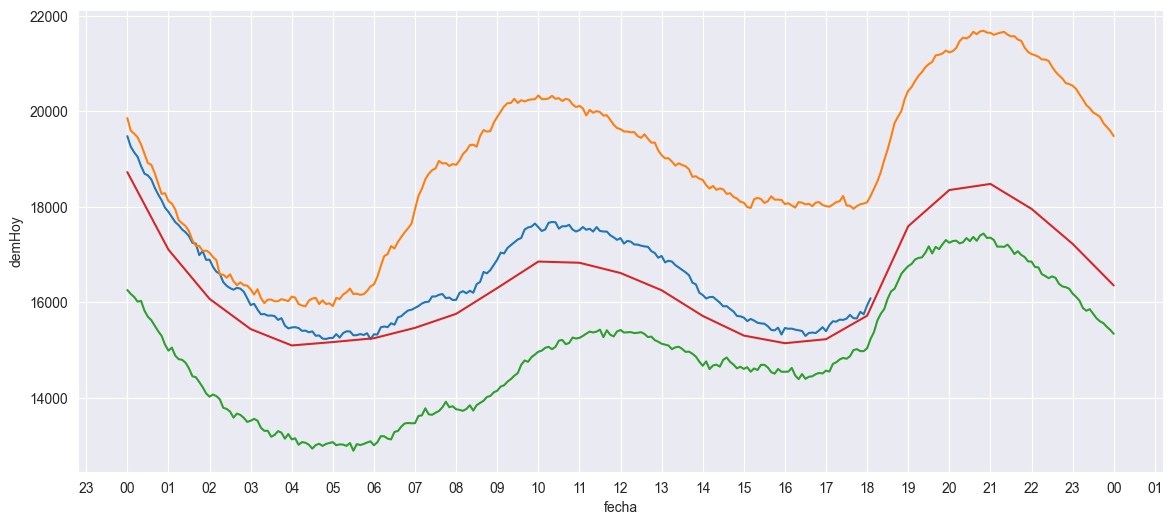

In [7]:
fig, ax = plt.subplots(figsize=(14,6))
sns.lineplot(data=df_demanda, y='demHoy', x='fecha', ax=ax)
sns.lineplot(data=df_demanda, y='demAyer', x='fecha', ax=ax)
sns.lineplot(data=df_demanda, y='demSemanaAnt', x='fecha', ax=ax)
sns.lineplot(data=df_demanda, y='demPrevista', x='fecha', ax=ax)

ax.xaxis.set_major_locator(HourLocator(interval=1, tz=timezone('America/Argentina/Buenos_Aires')))
ax.xaxis.set_major_formatter(DateFormatter("%H", tz=timezone('America/Argentina/Buenos_Aires')))

plt.show()

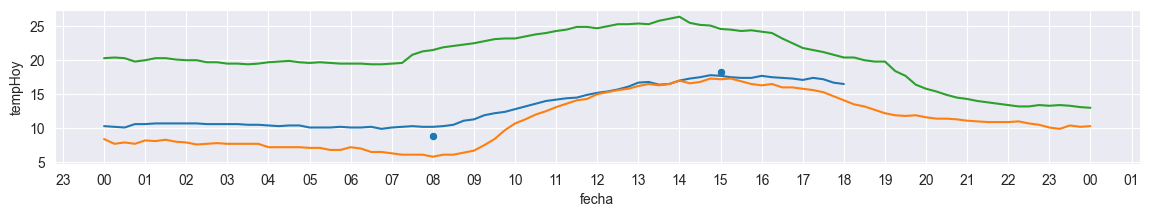

In [11]:
fig, ax = plt.subplots(figsize=(14,2))
sns.lineplot(data=df_demanda, y='tempHoy', x='fecha', ax=ax)
sns.lineplot(data=df_demanda, y='tempAyer', x='fecha', ax=ax)
sns.lineplot(data=df_demanda, y='tempSemanaAnt', x='fecha', ax=ax)
sns.scatterplot(data=df_demanda, y='tempPrevista', x='fecha', ax=ax)

ax.xaxis.set_major_locator(HourLocator(interval=1, tz=timezone('America/Argentina/Buenos_Aires')))
ax.xaxis.set_major_formatter(DateFormatter("%H", tz=timezone('America/Argentina/Buenos_Aires')))

plt.show()

In [ ]:
df_generacion = pd.DataFrame(dem_gen_region['generacion'])
df_generacion